In [54]:
from datasets import split_data, get_imagenet_dataset, get_class
from conformal_prediction import (
    softmax_conformal_score,
    get_calibration_scores,
    predict_conformal_set,
    calculate_thresholds
)
from torch.utils.data import DataLoader
from torchvision.models import EfficientNet_B1_Weights, efficientnet_b1
import torch
from constants import IMAGENET_CLASSES_DICT
from utils import plot_top_k_predictions
from collections import Counter

device = "cuda" if torch.cuda.is_available() else "cpu"

In [55]:
IMAGENET_PATH = "datasets"
BATCH_SIZE = 128

In [56]:
model_name = "efficientnet_b1"
model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1).to(device)
transform = EfficientNet_B1_Weights.IMAGENET1K_V1.transforms()

In [57]:
dataset = get_imagenet_dataset(IMAGENET_PATH, transform=transform)
test_dataset, calibrate_dataset = split_data(dataset, 0.02)

## Calibration

In [58]:
calibrate_loader = DataLoader(calibrate_dataset, batch_size=BATCH_SIZE, shuffle=False)

calibration_scores = get_calibration_scores(
    model, calibrate_loader, softmax_conformal_score, device
)

calib_len = len(calibration_scores)

100%|██████████| 8/8 [00:27<00:00,  3.43s/it]


## Conformal Prediction

In [59]:
CLASS = 985
ALPHA_TO_TEST = [0.01, 0.025, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5]

In [60]:
class_subset = get_class(test_dataset, CLASS)
class_loader = DataLoader(class_subset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Class {CLASS}: {IMAGENET_CLASSES_DICT[CLASS]}")
print(f"Number of images: {len(class_subset)}")

Class 985: daisy
Number of images: 49


In [61]:
counters = {}
for alpha in ALPHA_TO_TEST:
    counter = Counter()
    threshold = calculate_thresholds(calibration_scores, alpha, calib_len)

    predictions_sets = predict_conformal_set(
        model, class_loader, softmax_conformal_score, threshold, device
    )

    for prediction_set in predictions_sets:
        if len(prediction_set) == 0:
            counter["EMPTY"] += 1
        else:
            counter.update(prediction_set)

    counters[alpha] = counter

/mnt/d/Tomasz/Pulpit/Trustworthy/conformal_bias_detection/utils.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


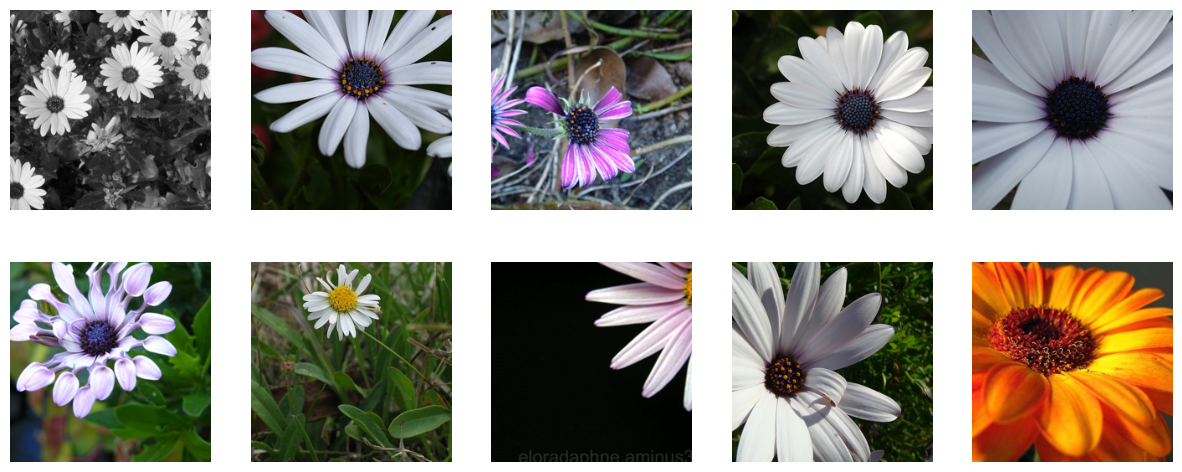

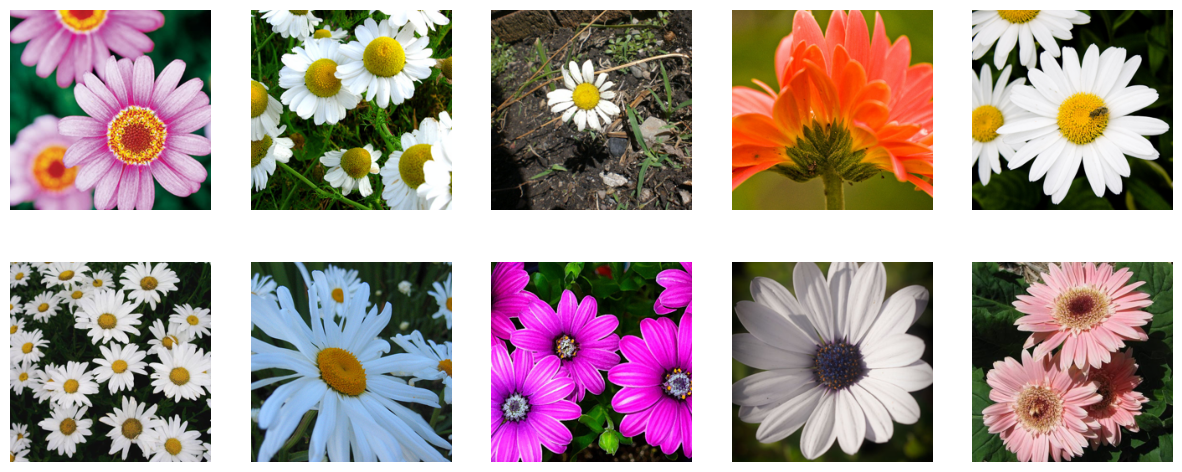

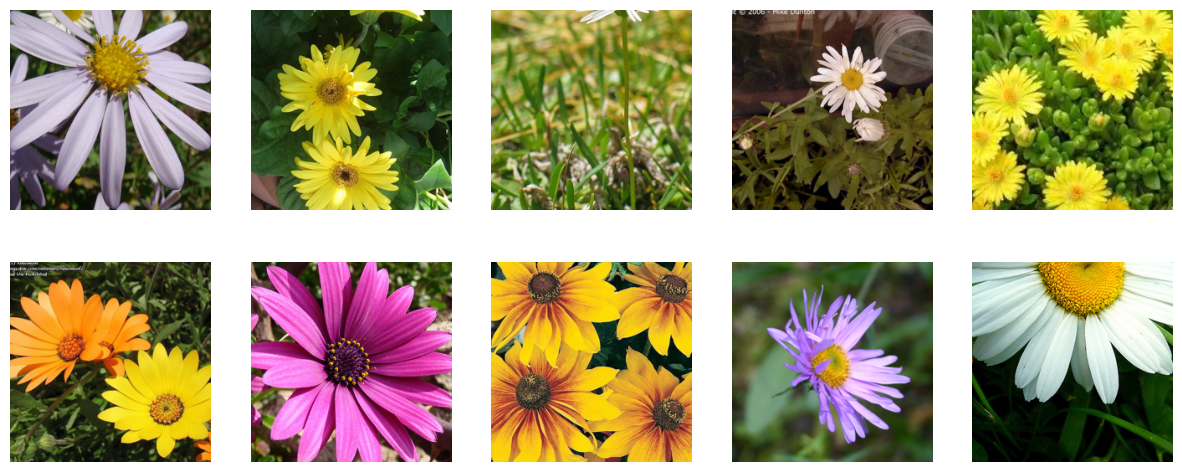

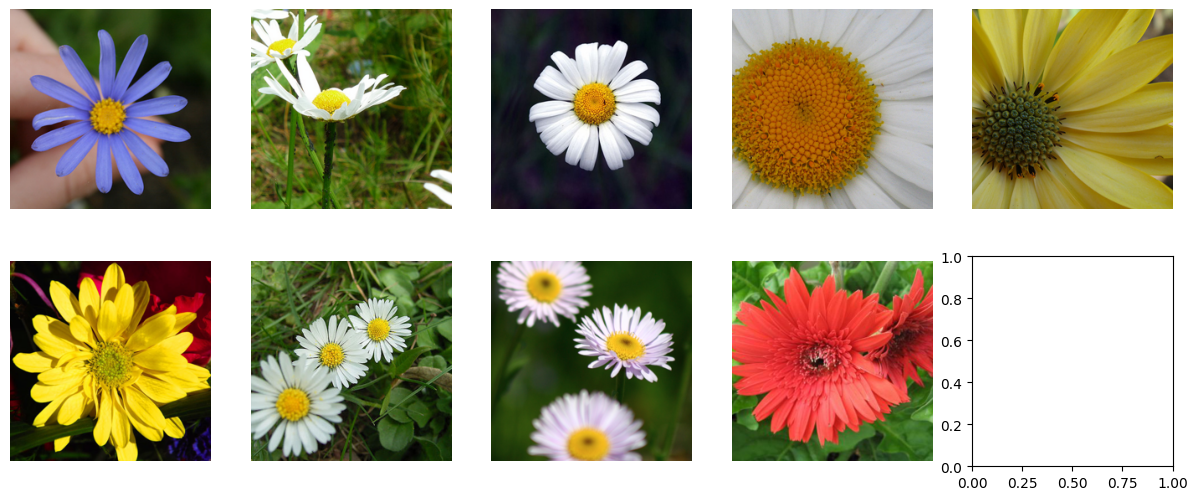

In [62]:
plot_top_k_predictions(counters, 5, IMAGENET_CLASSES_DICT, model_name, CLASS, save_root="figs", dataset=class_subset)